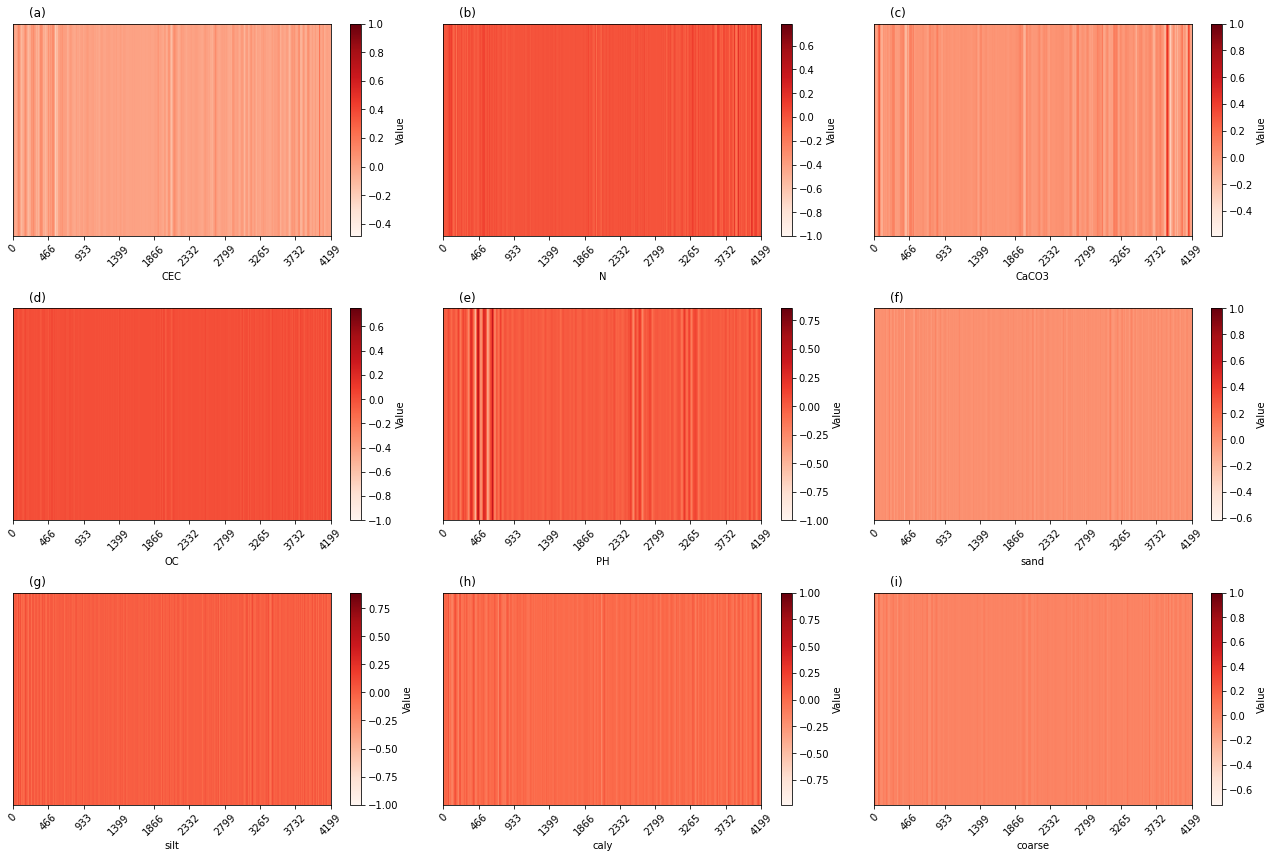

In [33]:
import pandas as pd
# 定义自定义标签
custom_labels = ['CEC', 'N', 'CaCO3', 'OC', 'PH', 'sand', 'silt', 'caly', 'coarse']


# 从 CSV 文件中读取数据并创建 DataFrame 对象
df = pd.read_csv('rusult.csv')
array_data = df.to_numpy()
plot_heatmap(array_data, custom_labels)

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(data, custom_labels, output_file='heatmap_custom_labels.png', dpi=300):
    # 设置全局字体为Times Roman
    plt.rcParams['font.family'] = 'Times New Roman'

    # 计算子图行列数
    num_matrices = len(data)
    num_rows = int(np.sqrt(num_matrices))
    num_cols = int(np.ceil(num_matrices / num_rows))

    # 创建子图网格，增加整体图的宽度
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 12))

    # 遍历每个子图，绘制热力图
    for i, ax in enumerate(axs.flat):
        if i < num_matrices:
            # 获取当前矩阵的数据
            matrix_data = data[i]

            # 绘制热力图
            im = ax.imshow(matrix_data.reshape(1, -1), cmap='Reds', aspect='auto')

            # 设置 x 轴刻度
            matrix_size = len(matrix_data)
            num_ticks = 10
        
            
            x_ticks = np.linspace(0, matrix_size - 1, num_ticks, dtype=int)
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_ticks, rotation=45)

            ax.set_yticks([])

            # 在子图左上角添加标注
            ax.text(0.05, 1.08, '({})'.format(chr(ord('a') + i)), transform=ax.transAxes,
                    fontsize=12, va='top')

            # 设置自定义的 x 轴标签
            ax.set_xlabel(custom_labels[i])

            # 添加颜色条
            cbar = fig.colorbar(im, ax=ax)
            cbar.set_label('Value')

    # 调整子图布局
    plt.tight_layout()

    # 保存图像并指定 dpi
    plt.savefig(output_file, dpi=dpi)
    plt.show()


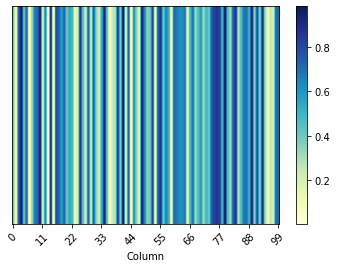

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 生成一维数组（一行多列）
data = np.random.rand(100)

# 将一维数组转换为二维数组
num_cols = len(data)
data_matrix = np.reshape(data, (1, num_cols))

# 绘制热力图
plt.imshow(data_matrix, cmap='YlGnBu', aspect='auto')

# 自定义横轴和删除纵轴的刻度
num_ticks = 10  # 设置横轴刻度数量
x_ticks = np.linspace(0, num_cols - 1, num_ticks, dtype=int)  # 生成横轴刻度
plt.xticks(x_ticks, rotation=45)  # 设置横轴刻度及旋转角度
plt.yticks([])  # 删除纵轴刻度

# 添加横向坐标的标注
plt.xlabel('Column')

plt.colorbar()  # 添加颜色条
plt.show()

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline   # 引入管道简化学习流程
from sklearn.preprocessing import StandardScaler # 由于SVR基于距离计算，引入对数据进行标准化的类
from sklearn.model_selection import GridSearchCV  # 引入网格搜索调优
from sklearn.model_selection import cross_val_score # 引入K折交叉验证
import matplotlib.pyplot as plt
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

class AlexNet(nn.Module):
    def __init__(self, num_classes=1, reduction=16):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # conv1
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv2
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv3
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv4
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv5
            nn.Conv1d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=192),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # SELayer(256, reduction),
            # nn.LeakyReLU(inplace=True),
        )
        self.reg = nn.Sequential(
            nn.Linear(25152, 1000),  #根据自己数据集修改
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.Linear(1000, 500),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(500, num_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.flatten(start_dim=1)
        out = self.reg(out)
        return out


def data_reading(data_path,label_index=8):
    Nirdata = pd.read_csv(data_path)
    X= Nirdata.values[:,:-12]
    Y= Nirdata.values[:,-12]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    print("训练集特征数据大小:", X_train.shape)
    print("测试集特征数据大小:", X_test.shape)
    print("训练集目标数据大小:", y_train.shape)
    print("测试集目标数据大小:", y_test.shape)
    return X_train, X_test, y_train, y_test

def print_shape(X):
    if isinstance(X, dict):
        print("Input X is a dictionary")
    elif isinstance(X, list):
        print("Input X is a list")
        print("Length of X:", len(X))
    elif isinstance(X, np.ndarray):
        print("Input X is a numpy array")
        print("Shape of X:", X.shape)
    elif torch.is_tensor(X):
        print("Input X is a PyTorch tensor")
        print("Shape of X:", tuple(X.size()))
    else:
        print("Unknown input type")

def error_caculate(y_tes,y_pred):
    r2 = r2_score(y_tes, y_pred)
    mse=mean_squared_error(y_tes, y_pred)
    mae=mean_absolute_error(y_tes, y_pred)
    return r2,mse,mae

# def grad(model):
#     Nirdata = pd.read_csv('./LUCAS.SOIL_corr.csv')
#     X_test= Nirdata.values[:1000, :-12]
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     X_test = torch.unsqueeze(torch.tensor(X_test, dtype=torch.float32), 1).to(device)

#     ig = IntegratedGradients(model)

#     ig_attr_test = ig.attribute(X_test,internal_batch_size=500, n_steps=200)
#     ig_attr_test_sum = ig_attr_test.detach().cpu().numpy().sum(0)
#     ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
#     y_re = ig_attr_test_norm_sum
#     df = pd.DataFrame(y_re)
#     df.to_csv('rusult.csv', index=False)
#     return y_re


def index(X_sec, y_re, delta):
    # 按照重要性从大到小排序y_re，并找到保留前delta%的阈值
    sorted_indices = np.argsort(y_re)[::-1]
    threshold_index = int(delta * len(y_re))
    # 找到保留前delta%的数据对应的列索引
    selected_indices = sorted_indices[:threshold_index]
    # 使用这些索引筛选X_sec数据集的列
    X_filtered = X_sec[:, selected_indices]
    return X_filtered

def model_PLSR(X_train, Y_train, X_test):
    # 根据X_train的列数动态设置n_components的大小
    n_components = min(X_train.shape[1], 200)
    model = PLSRegression(n_components=n_components)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return y_pred

data_path='./LUCAS.SOIL_corr.csv'
X_train, X_test, y_train, y_test=data_reading(data_path,label_index=8)
model_path = "./12_model_epoch_500.pth"
model=AlexNet()
model.load_state_dict(torch.load(model_path))
#model=load_model(model_path)

训练集特征数据大小: (14351, 4200)
测试集特征数据大小: (3588, 4200)
训练集目标数据大小: (14351,)
测试集目标数据大小: (3588,)


<All keys matched successfully>

In [3]:
import torch
import torch.nn.functional as F
from captum.attr import KernelShap
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation,DeepLiftShap

def grad(model):
    Nirdata = pd.read_csv('./LUCAS.SOIL_corr.csv')
    X_test= Nirdata.values[:20, :-12]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X_test = torch.unsqueeze(torch.tensor(X_test, dtype=torch.float32), 1).to(device)
    #ig = GradientShap(model)
    # 生成随机噪声
    #ig = DeepLift(model)
    #ig = KernelShap(model)

    baseline=torch.rand_like(X_test) * 0.1  #torch.zeros_like(X_test)#torch.rand_like(X_test) * 0.1  # 乘以一个小数值以确保在合理范围内
    #ig_attr_test, delta = ig.attribute(X_test, baselines=baseline_dist,return_convergence_delta=True)
    #ig_attr_test, delta = ig.attribute(X_test, baselines=baseline_dist, return_convergence_delta=True)
    #ig_attr_test = ig.attribute(X_test, baseline)
    #ig =DeepLiftShap(model)
    ig=IntegratedGradients(model)
    ig_attr_test, delta =ig.attribute(X_test,baselines=baseline, return_convergence_delta=True)
    #ig_attr_test, delta =ig.attribute(X_test,internal_batch_size=2000,baselines=baseline,  n_steps=600, return_convergence_delta=True)
    
    #ig_attr_test = ig.attribute(X_test,internal_batch_size=1000, n_steps=200)
    ig_attr_test_sum = ig_attr_test.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    y_re = ig_attr_test_norm_sum
    df = pd.DataFrame(y_re)
    df.to_csv('rusult.csv', index=False)
    return y_re,delta

y_re,delta=grad(model)
delta = delta.cpu().numpy()

# 计算平均值
mean_delta = np.mean(delta)
# 计算标准差
std_delta = np.std(delta)
print("平均值:", mean_delta)
print("标准差:", std_delta)



平均值: 0.22706385052060582
标准差: 0.8966949256543463


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'

def plot_and_save(r2_values, delta_values):
    num_rows = r2_values.shape[0]
    titles = ['CEC', 'N', 'CaCO3', 'OC', 'PH', 'sand', 'silt', 'clay', 'coarse']
    fig, axs = plt.subplots(3, 3, figsize=(12, 8))

    for i, ax in enumerate(axs.flat):
        r2_values_row = r2_values[i]
        ax.scatter(delta_values, r2_values_row, label='R2', color='blue')
        ax.plot(delta_values, r2_values_row, linestyle='-', color='gray')
        ax.set_title(titles[i])
        ax.set_xlabel('The proportion of data points')
        ax.set_ylabel('R2')
        ax.grid(True)
        #ax.legend()
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig('plot.png', dpi=300)  # 以最高像素存储图片
    plt.close()  # 关闭图形窗口，避免在函数调用后显示图形

# 创建示例的 r2_values 和 delta_values
# num_rows = 9
# num_columns = 20
# r2_values = np.random.rand(num_rows, num_columns)
r2_values = np.genfromtxt('Parade.csv', delimiter=',')
delta_values = np.arange(1, 0, -0.05)

# 调用函数绘制并保存图片
plot_and_save(r2_values, delta_values)


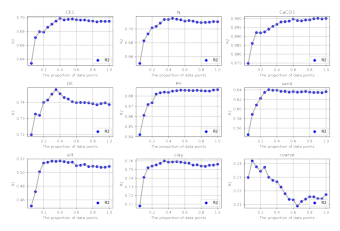

In [4]:
import matplotlib.pyplot as plt

# 读取图像文件
image = plt.imread('./plot.png')

# 显示图像
plt.imshow(image)
plt.axis('off')  # 关闭坐标轴
plt.show()

In [2]:
import torch
import torch.nn.functional as F



def grad(model):
    Nirdata = pd.read_csv('./LUCAS.SOIL_corr.csv')
    X_test= Nirdata.values[:2000, :-12]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X_test = torch.unsqueeze(torch.tensor(X_test, dtype=torch.float32), 1).to(device)
    ig = GradientShap(model)
    # 生成随机噪声
    
    baseline_dist=torch.rand_like(X_test) * 0.1  #torch.zeros_like(X_test)#torch.rand_like(X_test) * 0.1  # 乘以一个小数值以确保在合理范围内
    #ig_attr_test, delta = ig.attribute(X_test, baselines=baseline_dist,return_convergence_delta=True)
    ig_attr_test, delta = ig.attribute(X_test, baselines=baseline_dist, return_convergence_delta=True)
    
    #ig = IntegratedGradients(model)
    #ig_attr_test, delta = ig.attribute(X_test,internal_batch_size=3000, n_steps=600, return_convergence_delta=True)
    
    #ig_attr_test = ig.attribute(X_test,internal_batch_size=1000, n_steps=200)
    ig_attr_test_sum = ig_attr_test.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    y_re = ig_attr_test_norm_sum
    df = pd.DataFrame(y_re)
    df.to_csv('rusult.csv', index=False)
    return y_re,delta

y_re,delta=grad(model)
delta = delta.cpu().numpy()
# 计算平均值
mean_delta = np.mean(delta)
# 计算标准差
std_delta = np.std(delta)
print("平均值:", mean_delta)
print("标准差:", std_delta)


平均值: 0.0329635
标准差: 2.2276888


In [3]:
import torch
import torch.nn.functional as F



def grad(model):
    Nirdata = pd.read_csv('./LUCAS.SOIL_corr.csv')
    X_test= Nirdata.values[:2000, :-12]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X_test = torch.unsqueeze(torch.tensor(X_test, dtype=torch.float32), 1).to(device)
    #ig = GradientShap(model)
    # 生成随机噪声
    
    #baseline_dist=torch.rand_like(X_test) * 0.1  #torch.zeros_like(X_test)#torch.rand_like(X_test) * 0.1  # 乘以一个小数值以确保在合理范围内
    #ig_attr_test, delta = ig.attribute(X_test, baselines=baseline_dist,return_convergence_delta=True)
    #ig_attr_test, delta = ig.attribute(X_test, baselines=baseline_dist, return_convergence_delta=True)
    
    ig = IntegratedGradients(model)
    ig_attr_test, delta = ig.attribute(X_test,internal_batch_size=1000, n_steps=600, return_convergence_delta=True)
    
    #ig_attr_test = ig.attribute(X_test,internal_batch_size=1000, n_steps=200)
    ig_attr_test_sum = ig_attr_test.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    y_re = ig_attr_test_norm_sum
    df = pd.DataFrame(y_re)
    df.to_csv('rusult.csv', index=False)
    return y_re,delta

y_re,delta=grad(model)
delta = delta.cpu().numpy()
# 计算平均值
mean_delta = np.mean(delta)
# 计算标准差
std_delta = np.std(delta)
print("平均值:", mean_delta)
print("标准差:", std_delta)


平均值: 0.0033657989
标准差: 1.5822508


In [8]:
import pandas as pd 
import numpy as np 
data_path='./rusult.csv'
result = pd.read_csv(data_path)
print(result.shape)
top_10_indices = np.argsort(-result, axis=1)[:, :10]

# 对数组中的每个元素进行除以2并加上400
top_10_indices = top_10_indices / 2 + 400

# 打印结果
print("每行数值最大的前10个数值的列索引：")
print(top_10_indices)

# 将 DataFrame 写入 CSV 文件
output_file = "result11.csv"
df.to_csv(output_file, index=False)

print("结果已保存到", output_file)

(9, 4200)
每行数值最大的前10个数值的列索引：
[[2424.5 2425.  2425.5 2426.  2448.5 2441.5  656.5 2440.5  648.5  650. ]
 [2213.5 2454.5 2048.5 2049.5 2348.  2469.5 2050.5 2349.5 2430.5  664.5]
 [2341.  2339.  2343.  2342.  2337.   437.  2476.5 2477.  2475.   439. ]
 [1404.5 2109.5 1916.5 2204.5 2479.5 2469.5  475.5 1948.5 1396.5  653.5]
 [ 631.   630.5  727.   633.   725.   635.   628.5  726.5  632.5  679. ]
 [ 673.5  605.5  671.5  675.5  607.5  669.5  609.5  613.5  603.5  611.5]
 [ 503.5  505.5  507.5 2112.   527.5  529.5  495.  2114.   493.  1935.5]
 [ 473.5  505.5  469.5 1452.   595.5  608.5  591.5  560.5  509.5  471.5]
 [ 425.5  754.5  775.5  756.5  486.5  488.5  423.5  517.5  509.5  490.5]]
结果已保存到 result11.csv


In [27]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
data_path='./LUCAS.SOIL_corr.csv'
Nirdata = pd.read_csv(data_path)
# print_shape(Nirdata)
# # # 删除第 -2、-3、-8 列
# # indices_to_delete = [-2, -3, -8]
# # Nirdata = np.delete(Nirdata, indices_to_delete, axis=1)
# # 删除指定列
# 删除指定列
columns_to_delete = Nirdata.columns[[-2, -3, -8]]  # 要删除的列的索引
Nirdata = Nirdata.drop(columns=columns_to_delete)
Nirdata= pd.DataFrame(Nirdata)
# # 将 DataFrame 转换为 NumPy 数组并选取列
#print(Nirdata.iloc[0, -9:].values)
X= Nirdata.values[:,:-9]
Y= Nirdata.values[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
# 计算最大值、最小值、均值和标准差
print('y_train')
max_values = np.max(y_train, axis=0)
min_values = np.min(y_train, axis=0)
mean_values = np.mean(y_train, axis=0)
std_values = np.std(y_train, axis=0)
print(max_values)
print(min_values)
print(mean_values)
print(std_values)
print('y_test')
max_values = np.max(y_test, axis=0)
min_values = np.min(y_test, axis=0)
mean_values = np.mean(y_test, axis=0)
std_values = np.std(y_test, axis=0)
print(max_values)
print(min_values)
print(mean_values)
print(std_values)
# # 打印 X 的第一行的后九列
# print("后九列的第一行：", X[0, -9:])

# # 打印出后九列的第一行
# print("后九列的第一行：", Nirdata[0, -9:])




y_train
104.3
0.0
14.092852276246516
10.45371599399772
y_test
137.0
0.0
14.666889632107024
11.316159685854407


In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline   # 引入管道简化学习流程
from sklearn.preprocessing import StandardScaler # 由于SVR基于距离计算，引入对数据进行标准化的类
from sklearn.model_selection import GridSearchCV  # 引入网格搜索调优
from sklearn.model_selection import cross_val_score # 引入K折交叉验证
import matplotlib.pyplot as plt

def print_shape(X):
    if isinstance(X, dict):
        print("Input X is a dictionary")
    elif isinstance(X, list):
        print("Input X is a list")
        print("Length of X:", len(X))
    elif isinstance(X, np.ndarray):
        print("Input X is a numpy array")
        print("Shape of X:", X.shape)
    elif torch.is_tensor(X):
        print("Input X is a PyTorch tensor")
        print("Shape of X:", tuple(X.size()))
    else:
        print("Unknown input type")

def error_caculate(y_tes,y_pred):
    r2 = r2_score(y_tes, y_pred)
    mse=mean_squared_error(y_tes, y_pred)
    mae=mean_absolute_error(y_tes, y_pred)
    return r2,mse,mae

def index_selection(X_sec, y_re, delta):
    # 按照重要性从大到小排序y_re，并找到保留前delta%的阈值
    sorted_indices = np.argsort(y_re)[::-1]
    threshold_index = int(delta * len(y_re))
    # 找到保留前delta%的数据对应的列索引
    selected_indices = sorted_indices[:threshold_index]
    # 使用这些索引筛选X_sec数据集的列
    X_filtered = X_sec[:, selected_indices]
    return X_filtered

def model_PLSR(X_train, Y_train, X_test):
    # 根据X_train的列数动态设置n_components的大小
    n_components = min(X_train.shape[1], 200)
    model = PLSRegression(n_components=n_components)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return y_pred

# 从 CSV 文件中读取数据并创建 DataFrame 对象
df = pd.read_csv('rusult.csv')
# 从 DataFrame 中提取数组数据
y_re_sum = df.to_numpy()
print_shape(y_re_sum)
data_path='./LUCAS.SOIL_corr.csv'

Nirdata = pd.read_csv(data_path)
X= Nirdata.values[:,:-12]

# 创建空数组来存储每次迭代的R2
r2_sum = []


# 循环迭代不同的y_re
for index, y_re_row in enumerate(y_re_sum):
    # 根据当前的y_re行数设置label_index
    label_index = index + 1
    
    #y_re_row=y_re_row.reshape(1, -1)
    #print_shape(y_re)

    # 读取相应的数据
    print('%')
    Y= Nirdata.values[:,-label_index]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    print('#')


    
    # 创建空数组来存储每次迭代的R2、MSE、MAE
    r2_values = []
    mse_values = []
    mae_values = []
    
    # 循环迭代不同的delta值
    for delta in np.arange(0.05, 0, -0.05):
        # 使用当前的delta值进行数据筛选
        X_filtered = index_selection(X_train, y_re_row, delta)
        X_test1 = index_selection(X_test, y_re_row, delta)
        #print_shape(X_filtered)
        # X_filtered = np.squeeze(X_filtered)
        # X_test1 = np.squeeze(X_test1)
        # 使用筛选后的数据进行模型训练和预测
        y_pred = model_PLSR(X_filtered, y_train, X_test1)

        # 计算R2、MSE和MAE
        r2, mse, mae = error_caculate(y_test, y_pred)
        print(r2)
        # 将结果存储到数组中
        r2_values.append(r2)
        mse_values.append(mse)
        mae_values.append(mae)
    # 将r2_values存储到r2_sum中
    r2_sum.append(r2_values)

np.savetxt('Parade.csv', r2_sum, delimiter=',')

Input X is a numpy array
Shape of X: (9, 4200)
%
#
-4838.016650776442
%
#
0.34253638668498865
%
#
0.2119244673496169
%
#
0.6783033262955498
%
#
0.856493980423763
%
#
0.7000454522143083
%
#
0.8411642505304671
%
#
0.8548734171677771
%
#
0.5497413244062104


In [11]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def print_shape(X):
    if isinstance(X, dict):
        print("Input X is a dictionary")
    elif isinstance(X, list):
        print("Input X is a list")
        print("Length of X:", len(X))
    elif isinstance(X, np.ndarray):
        print("Input X is a numpy array")
        print("Shape of X:", X.shape)
    elif torch.is_tensor(X):
        print("Input X is a PyTorch tensor")
        print("Shape of X:", tuple(X.size()))
    else:
        print("Unknown input type")

def index_selection(y_re, delta):
    # 按照重要性从大到小排序y_re，并找到保留前delta%的阈值
    sorted_indices = np.argsort(y_re)[::-1]
    threshold_index = int(delta * len(y_re))
    # 找到保留前delta%的数据对应的列索引
    selected_indices = sorted_indices[:threshold_index]
    return selected_indices

# 从 CSV 文件中读取数据并创建 DataFrame 对象
df = pd.read_csv('rusult.csv')
# 从 DataFrame 中提取数组数据
y_re_sum = df.to_numpy()
print_shape(y_re_sum)

# 创建示例的 y_re 数据
#y_re = np.random.rand(9, 20)

# 按照指定顺序生成 delta 数组
delta_sequence = [0.1,0.1,0.05,0.05,0.05,0.15,0.1,0.05,0.1]
#0.1,0.1,0.05,0.05,0.05,0.15,0.1,0.05,0.65
#0.4, 0.45, 0.6, 0.35, 0.55, 0.3, 0.3, 0.35, 0.1
# 创建一个空列表，用于存储九个返回结果
selected_indices_list = []

# 调用 index_selection 函数九次，并将结果存储在 selected_indices_list 中
for i, delta in enumerate(delta_sequence):
    selected_indices = index_selection(y_re_sum[i,:], delta)
    selected_indices_list.append(selected_indices)

# 将列表转换为 numpy 数组
#selected_indices_array = np.array(selected_indices_list)

# 打印结果
#print(selected_indices_list)

Input X is a numpy array
Shape of X: (9, 4200)


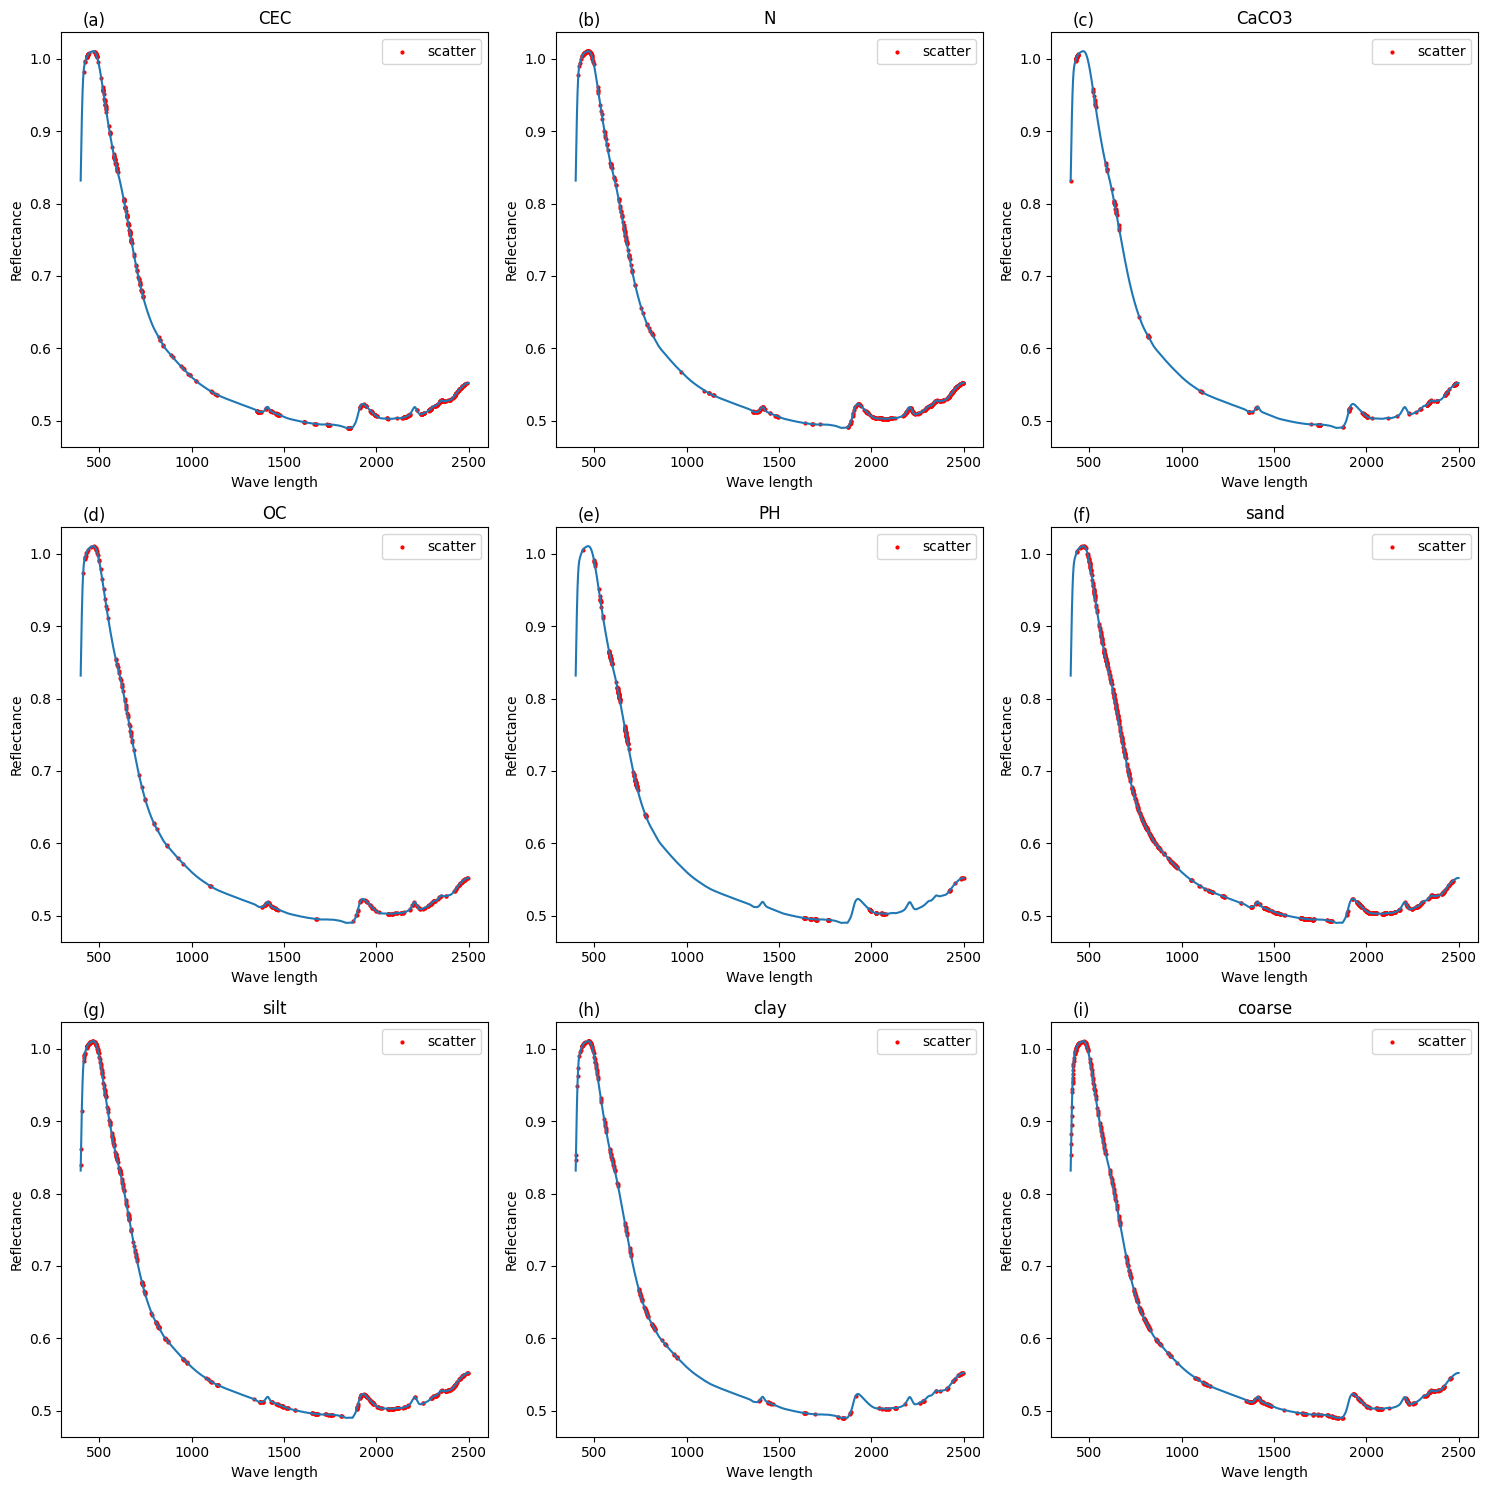

In [16]:
import numpy as np
import matplotlib.pyplot as plt

data_path='./LUCAS.SOIL_corr.csv'
Nirdata = pd.read_csv(data_path)
Nirdata= pd.DataFrame(Nirdata)
X= Nirdata.values[0,:-12]

# 创建横轴坐标，从400到2500，以0.5为步长的等差数列
x = np.arange(400, 2500, 0.5)

# 假设 X 是一个长度为 4200 的数组，里面记录了纵轴坐标
# 这里使用随机生成的数据作为示例
#X = np.random.rand(4200)

# 假设 index_read 是一个包含九行多列的数组，每一行都存储了需要画上散点的坐标点的索引
# 这里使用随机生成的数据作为示例
index_read =selected_indices_list

# 创建画板
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# 九个图片的标题
titles = ['CEC', 'N', 'CaCO3', 'OC', 'PH', 'sand', 'silt', 'clay', 'coarse']

# 绘制九张图片
for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        ax.plot(x, X)  # 绘制折线图
        ax.scatter(x[index_read[i*3 + j]], X[index_read[i*3 + j]], color='red', label='scatter', s=4, marker='o')  # 绘制散点图
        ax.set_title(titles[i*3 + j])  # 设置标题
        ax.set_xlabel('Wave length')  # 设置横轴标签
        ax.set_ylabel('Reflectance')  # 设置纵轴标签
        ax.legend()  # 显示图例
        ax.text(0.05, 1.05, f'({chr(97 + i*3 + j)})', transform=ax.transAxes, fontsize=12, verticalalignment='top')
# 调整子图之间的间距
plt.tight_layout()
#bbox=dict(facecolor='white', alpha=0.5)
# 保存图片
plt.savefig('nine_plots.png', dpi=300)

# 显示图形
plt.show()